<a href="https://colab.research.google.com/github/FrankJRix/lab_util/blob/main/Copia_di_lab_util_provvisorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Per funzionare la demo ha bisogno del csv dei dati di un filtro rinominato 'pa.csv', io ho usato quelli della prima esperienza col valore problematico corretto

\begin{table}[H]
\centering
\caption{} %inserire caption
\label{} %inserire label
\begin{tabular}{rll}
\toprule
 $\nu(Hz)$ &     $V_{in} (V)$ &    $V_{out} (V)$ \\
\midrule
        10 & 0.763 $\pm$ 0.14 & 0.638 $\pm$ 0.28 \\
        20 & 0.744 $\pm$ 0.14 &  1.18 $\pm$ 0.28 \\
        50 & 0.769 $\pm$ 0.14 &  2.58 $\pm$ 0.28 \\
        70 & 0.792 $\pm$ 0.14 &  3.35 $\pm$ 0.28 \\
        85 & 0.738 $\pm$ 0.14 &  3.73 $\pm$ 0.28 \\
        95 & 0.775 $\pm$ 0.14 &  3.99 $\pm$ 0.28 \\
       100 &  0.75 $\pm$ 0.14 &  4.11 $\pm$ 0.28 \\
       105 & 0.738 $\pm$ 0.14 &  4.16 $\pm$ 0.28 \\
       110 & 0.775 $\pm$ 0.14 &  4.19 $\pm$ 0.28 \\
       200 & 0.744 $\pm$ 0.14 &  5.11 $\pm$ 0.28 \\
       500 & 0.763 $\pm$ 0.14 &  5.53 $\pm$ 0.28 \\
      1000 & 0.763 $\pm$ 0.14 &  5.69 $\pm$ 0.28 \\
      2000 & 0.769 $\pm$ 0.14 &   5.7 $\pm$ 0.28 \\
      5000 &  0.75 $\pm$ 0.14 &   5.7 $\pm$ 0.28 \\
     10000 &  0.75 $\pm$ 0.14 &   5.7 $\pm$ 0.28 \\
     20000 & 0.738 $\pm$ 0.14 &  5.64 $\pm$ 0.2

,vin(V),vout,vidiv,vodiv,dt(s),freq(Hz),err_vin,err_vout,T,err_T
0,0.763,0.6380,0.5,1,NaN,10,0.14,0.28,-1.554077,4.131740
1,0.744,1.1760,0.5,1,NaN,20,0.14,0.28,3.976688,2.635964
2,0.769,2.5750,0.5,1,NaN,50,0.14,0.28,10.497018,1.841896
3,0.792,3.3500,0.5,1,NaN,70,0.14,0.28,12.526393,1.698370
4,0.738,3.7250,0.5,1,NaN,85,0.14,0.28,14.061398,1.772369
5,0.775,3.9875,0.5,1,NaN,95,0.14,0.28,14.227980,1.683438
6,0.750,4.1125,0.5,1,NaN,100,0.14,0.28,14.780893,1.725850
7,0.738,4.1625,0.5,1,NaN,105,0.14,0.28,15.025958,1.748254
8,0.775,4.1875,0.5,1,NaN,110,0.14,0.28,14.653062,1.673104
9,0.744,5.1125,0.5,1,NaN,200,0.14,0.28,16.741208,1.702262


132 $\pm$ 17.6
1.62e+05 $\pm$ 4.48e+04


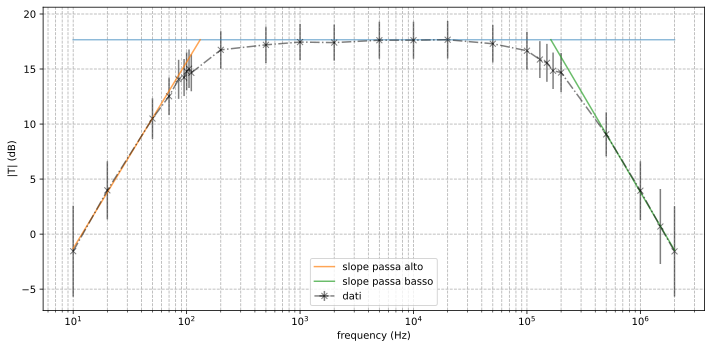

In [10]:
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import linregress as linfit
from scipy.optimize import curve_fit as cfit

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg') # se su colab, in locale commentata

# la parte sotto va commentata su colab e scommentata in locale su una macchina aggiornata
#import matplotlib_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

fil = 'tr_corretto_ex.csv'

# def funzioni

def errori_osc_volt(valori, div):
    """ si aspetta un array di valori misurati e uno di volt/div come da oscilloscopio
    in output array di errori """
    errors = []

    if len(valori) != len(div):
        print('mismatched input size')
        return
    
    for j in range(len(valori)):
        if div[j] >= 10e-3:
            percent = 0.03
        else:
            percent = 0.04

        scala = div[j]*8
        err = percent*scala + 0.005*scala

        errors.append(err)

        #print(f'{j+1}: ({valori[j]:.3g} +/- {err:.3g})V (scala: {scala}V)')
    
    errors = np.array(errors)
    #print('\n')

    return errors

def errori_osc_tempo(valori, div):
    """ si aspetta un array di valori misurati e uno di s/div come da oscilloscopio """
    errors = []

    if len(valori) != len(div):
        print('mismatched input size')
        return
    
    acc = 50e-6
    off = 200e-12
    factor = 16e-3 #16e-4 * num divisioni orizzontali

    for j in range(len(valori)):
        err = acc*valori[j] + off + factor*div[j]
        
        #print(f'{j+1}: ({valori[j]:.3g} +/- {err:.3g})s')
        errors.append(err)
    
    errors = np.array(errors)
    #print('\n')

    return errors

def leggi_csv(path):
    """ path relativo fino al .csv """
    data = pd.read_csv(path)
    data = data.replace(',','.', regex=True)
    data = data.apply(pd.to_numeric, errors='coerce')
    return data

def compute_phi(dt, err_t, f, err_f = []):
    """ si aspetta quattro (tre) array di valori di dt, errore su dt, frequenza e errore su frequenza (facoltativo)
    in output due array phi e err_phi """
    if len(dt) != len(f):
        print('mismatched input size')
        return
    if len(err_f) == 0:
        err_f = np.zeros(len(f))
    dt = np.array(dt)
    f = np.array(f)
    err_t = np.array(err_t)
    err_f = np.array(err_f)

    conv = 360/(2*np.pi)

    phi = 2*np.pi * f * dt
    phi = conv * phi

    err_phi = conv * np.sqrt((2*np.pi*f*err_t)**2+(2*np.pi*dt*err_f)**2)
    return phi, err_phi

def error_format(val, err):
    """ si aspetta un array di valori e uno di errori 
    in output array di stringhe formattate in latex pronte per tabella"""
    if len(val) != len(err):
        print('mismatched input size')
        return
    out = []
    for i in range(len(val)):
        tmp = f'{val[i]:.3g} $\pm$ {err[i]:.3g}'
        out.append(tmp)
    
    return out

def transf_func(vin, vout, err_vin = [], err_vout = []):
    """ quattro (due) array, V_in, V_out e rispettivi errori (facoltativi)
    output modulo e errore di T """
    vin = np.array(vin)
    vout = np.array(vout)
    if len(err_vin) == 0:
        err_vin = np.zeros(len(vin))
    else:
        err_vin = np.array(err_vin)
    if len(err_vin) == 0:
        err_vout = np.zeros(len(vout))
    else:
        err_vout = np.array(err_vout)

    x = 20 * np.log10(vout/vin)
    err_x = 20*np.sqrt( (err_vout/vout)**2 + (err_vin/vin)**2) / np.log(10)

    return x, err_x

def hor(x, q):
    return q

def fun(x, m, q):
    return m * x + q

def bode_plot(T, f, err_T, err_f = [],  phi = [], err_phi = [], n_pa = 0, n_pb = 0):
    """ sei (cinque) array, modulo di T, fase di T, frequenza e rispettivi errori (facoltativo quello su f)
    num di valori per calcolare freq di taglio per pa e pb (facoltativi, servono per fit)
    output grafici e stima di freq taglio """
    if len(err_f) == 0:
        err_f = np.zeros(len(f))
    if len(err_phi) == 0:
        err_phi = np.zeros(len(f))

    t = np.linspace(f.min(), f.max(), 2)
    T_max = T.max()

    plt.figure(figsize=(10,5))
    plt.errorbar(f, T, yerr=err_T, xerr=err_f, label='dati', marker='x', linestyle='-.', color='black', alpha = 0.5)
    plt.plot(t, np.ones(len(t))*T_max, alpha=0.5)

    if n_pa:
        l = np.log(f[:n_pa])

        par, cov = cfit(fun, l, T[:n_pa], sigma = err_T[:n_pa])
        err = np.sqrt(np.diag(cov))

        m = par[0]
        dm = err[0]
        q = par[1]
        dq = err[1]

        ft_pa = np.exp((T.max()-q)/m)
        err_ft_pa = np.sqrt( ((m*dq)**2+(q*dm)**2)*np.exp(2*(T_max - q)/m) / m**4)
        
        print(f'{ft_pa:.3g} $\pm$ {err_ft_pa:.3g}')

        t_pa = np.linspace(f.min(), ft_pa, 2)
        l_pa = np.log(t_pa)

        plt.plot(t_pa, m*l_pa + q, label='slope passa alto', alpha = 0.7)

    if n_pb:
        l = np.log(f[-n_pb:])

        par, cov = cfit(fun, l, T[-n_pb:], sigma = err_T[-n_pb:])
        err = np.sqrt(np.diag(cov))

        m = par[0]
        dm = err[0]
        q = par[1]
        dq = err[1]        

        ft_pb = np.exp((T.max()-q)/m)
        err_ft_pb = np.sqrt( ((m*dq)**2+(q*dm)**2)*np.exp(2*(T_max - q)/m) / m**4)
        
        print(f'{ft_pb:.3g} $\pm$ {err_ft_pb:.3g}')

        t_pb = np.linspace(f.max(), ft_pb, 2)
        l_pb = np.log(t_pb)

        plt.plot(t_pb, m*l_pb + q, label='slope passa basso', alpha = 0.7)

    plt.semilogx()
    plt.xlabel('frequency (Hz)')
    plt.ylabel('|T| (dB)')
    plt.grid(True, 'both', linestyle='--')

    plt.legend(loc='lower center')

    plt.tight_layout()
    plt.savefig("bode_T.svg", bbox_inches='tight')
    plt.show()

    if len(phi) > 0:
        plt.figure(figsize=(10,5))
        plt.errorbar(f, phi, yerr=err_phi, xerr=err_f, label='dati', marker='.', linestyle='-.', alpha = 0.5, color='black')
        plt.semilogx()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('$d\phi$ (deg)')
        

        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.savefig("bode_phi.svg", bbox_inches='tight')
        plt.show()

def analisi_risposta(path, n_pa = 0, n_pb = 0, has_dt = False):
    """ path: path al .csv
    n_pa: num misure per fit passa alto
    n_pb: num misure per fit passa basso
    has_dt: True se c'è l'analisi di phi, default False """
    data = leggi_csv(path)
    tab_misure = pd.DataFrame()
    tab_analisi = pd.DataFrame()
    
    tab_misure.insert(len(tab_misure.columns), '$\nu(Hz)$', data['freq(Hz)'])
    tab_analisi.insert(len(tab_analisi.columns), '$\nu(Hz)$', data['freq(Hz)'])

    err_vi = errori_osc_volt(data['vin(V)'], data['vidiv'])
    err_vo = errori_osc_volt(data['vout'], data['vodiv'])
    data.insert(len(data.columns), 'err_vin', err_vi)
    data.insert(len(data.columns), 'err_vout', err_vo)

    m_vin =  error_format(data['vin(V)'], data['err_vin'])
    m_vout =  error_format(data['vout'], data['err_vout'])

    T, err_T = transf_func(data['vin(V)'], data['vout'], data['err_vin'], data['err_vout'])
    data.insert(len(data.columns), 'T', T)
    data.insert(len(data.columns), 'err_T', err_T)

    a_T = error_format(T, err_T)

    tab_misure.insert(len(tab_misure.columns), '$V_{in} (V)$', m_vin)
    tab_misure.insert(len(tab_misure.columns), '$V_{out} (V)$', m_vout)
    
    tab_analisi.insert(len(tab_analisi.columns), '$|T| (dB)$', a_T)
    
    if has_dt:
        err_dt = errori_osc_tempo(data['dt(s)'], data['tdiv'])
        data.insert(len(data.columns), 'err_dt', err_dt)

        m_dt = error_format(data['dt(s)'], err_dt)
        tab_misure.insert(len(tab_misure.columns), '$dt (s)$', m_dt)

        phi , err_phi = compute_phi(data['dt(s)'], data['err_dt'], data['freq(Hz'])
        data.insert(len(data.columns), 'phi', phi)
        data.insert(len(data.columns), 'err_phi', err_phi)

        a_phi = error_format(phi, err_phi)
        tab_analisi.insert(len(tab_analisi.columns), '$\phi (deg)$', phi)
    
    print(r'\begin{table}[H]')
    print(r'\centering')
    print(r'\caption{} %inserire caption')
    print(r'\label{} %inserire label')
    tab_misure = tab_misure.to_latex(escape=False, index=False)
    print(tab_misure)
    print(r'\end{table}')
    print('\n\n')

    print(r'\begin{table}[H]')
    print(r'\centering')
    print(r'\caption{} %inserire caption')
    print(r'\label{} %inserire label')
    tab_analisi = tab_analisi.to_latex(escape=False, index=False)
    print(tab_analisi)
    print(r'\end{table}')
    print('\n\n')

    display(data)
    bode_plot(data['T'], data['freq(Hz)'], data['err_T'], n_pa=n_pa, n_pb=n_pb)

#playground

#esempio finale
analisi_risposta(fil, 3, 4)